A document to follow my progress through the 'emcee' package on Python, doing exercises to prepare for applying this knowledge to the final project. \
Firstly working through an example given in the documentation, url: https://emcee.readthedocs.io/en/stable/tutorials/quickstart/#quickstart \
 \

Using EnsembleSampler in the emcee package, which implements the Affine-Invariant MCMC Ensemble Sampler, which uses multiple 'walkers' to explore a probability distribution. 

$p(\vec{x}) \propto  \exp{\left[-\frac{1}{2}\left(\vec{x}-\vec{\mu}\right)^T\Sigma^{-1}\left(\vec{x}-\vec{\mu}\right)\right]} \\$
where $\vec{\mu}$ is an N-dimesional vector position of the mean density and $\Sigma$ is the square N by N covariance matrix. 

In [43]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Defining a function for p
def log_prob(x,mu,cov):            # emcee requires the logarithm of p
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

Our definition for the function uses two numpy functions: \
Firstly np.linalg.solve which solves the linear matrix equation $\Sigma^{-1}\left(\vec{x}-\vec{\mu}\right)$. Here, 'cov' refers to our covariance matrix $\Sigma$. \
Secondly, np.dot takes the dot product between diff and this matrix equation, thus defining the entire term. \
Importantly, the first 'diff' must be transpose in the mathematics, as shown above, for the dot product to be possible. This is because you cannot compute the product of a 1x3 by a 1x3 matrix - but you can for a 3x1 by 1x3 for example. \

In [44]:
ndim = 5                          # Setting up N-dimension for our distribution
np.random.seed(42)                # Seed for our random walk, gives reproducible numbers (can change seed)
means = np.random.rand(ndim)      # A 5D array defined by our seed

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))     # Creating a 5x5 covariance matrix using np.reshape
cov = np.triu(cov)                                            # Takes an 'upper triangle' of an array - zeros elements below leading diagonal. Use np.tril for the opposite
cov += cov.T - np.diag(cov.diagonal())                        # Mirrors array about the diagonal, by taking its transpose (cov.T) and summing to the array.
cov = np.dot(cov, cov)                                        # Dot product of the covariance array with itself

nwalkers = 32                                                 # Setting up 32 random walkers
p0 = np.random.rand(nwalkers, ndim)                           # Setting up our intial guess, which is a 32x5 array, corresponing to 32 walkers each with a unique starting guess for each dimension.

Now to actually include our MCMC solver, using EnsembleSampler from the emcee package. Important to note that the extra arguments called are applied to our function log_prob. Therefore, when we run the sampler, it uses log_prob(p0, means, cov) as its arguments. 

In [45]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])       # Setting up the sampler, and calling the correct variables
state = sampler.run_mcmc(p0, 100)                                                  # Saves a state after 100 random steps
sampler.reset()

In [46]:
sampler.run_mcmc(state, 10000);                 # Now run sampler for 10,000 steps
chain = sampler.get_chain()                     # get_chain creates an array, giving the values at each step for the array, hence the dimensions
print(chain.shape)

(10000, 32, 5)


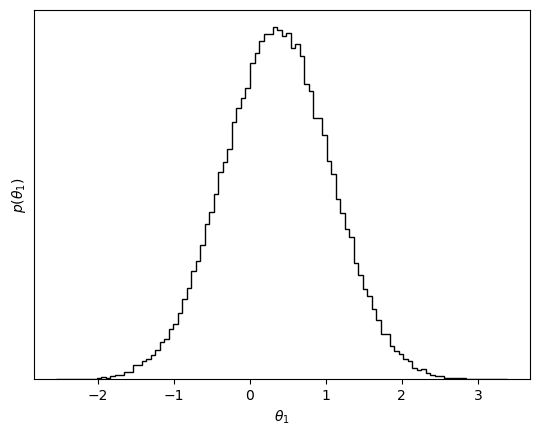

In [47]:
samples = sampler.get_chain(flat=True)                        # flat=True condenses the array by taking nstep*nwalkers for the first column                    
plt.hist(samples[:, 0], 100, color="k", histtype="step")      # Plotting a histogram of only the first column by extrating the data for a 1D array
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

We now get an obvious Gaussian distribution. This is expected, as we have essentially performed a random walk. \
\
Now we can retrieve various parameters of the fit, all stored within EnsembleSampler, such as mean acceptance fraction and mean autocorrelation time.

In [48]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction: 0.552
Mean autocorrelation time: 57.112 steps


Now to use the second resource, url: https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html \
This uses a fake dataset and model, and gives a probability distribution after the walk, which is more directly applicable to the project. \
The model uses linear regression with two predictor variables (x,y) and a predictor variable z, which are related by $ Z_n = \left[\alpha + \beta_x x_n + \beta_y y_n + \epsilon\right] $, where $\epsilon$ is a Gaussian noise term.

In [49]:
size_x = size_y = 20
x_true = np.random.uniform(0,10, size=size_x)           # Draws a number size_x of samples from a uniform distribtuion, between bounds given as first two arguments
y_true = np.random.uniform(-1,1, size=size_y)
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
eps_true = 0.5
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true           # Formula as stated above
z_obs = z_true + np.random.normal(0, eps_true, size=size_x)             # Adding a random Gaussian noise term

Text(0, 0.5, 'Z')

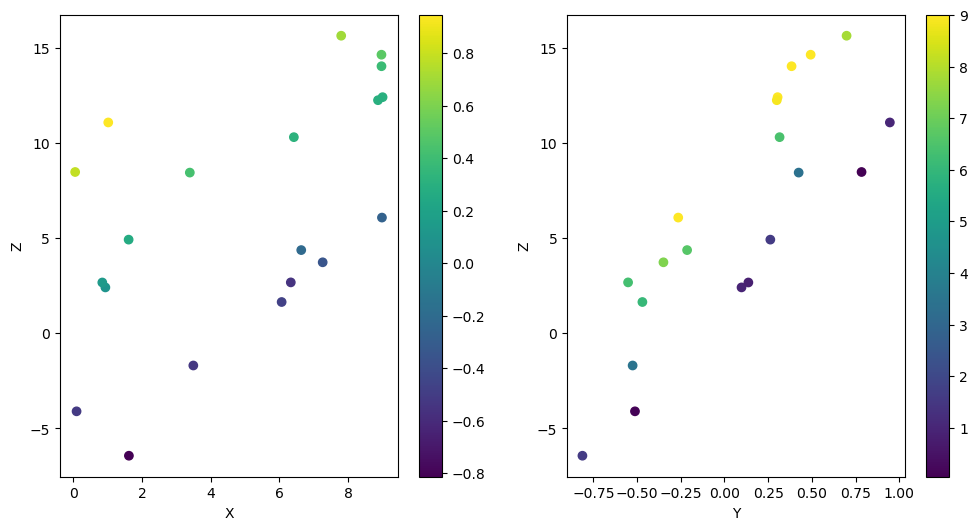

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')               # Colour bar for how closely the value corresponds to its x_true counterpart
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.subplot(1,2,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar()
plt.xlabel('Y')
plt.ylabel('Z')

Now we set up some initial probability distributions for our function

In [ ]:
from numpy import power, log, pi
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    alpha,betax,betay,eps = p
    # We're using only uniform priors, and only eps has a lower bound
    if eps <= 0:
        return -inf
    return 0

def lnlike(p, x, y, z):
    alpha,betax,betay,eps = p
    model = alpha + betax*x + betay*y
    # the likelihood is sum of the lot of normal distributions
    denom = power(eps,2)
    lp = -0.5*sum(power((z - model),2)/denom + log(denom) + log(2*pi))
    return lp

def lnprob(p, x, y, z):
    lp = lnprior(p)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(p, x, y, z)

nll = lambda *args: -lnlike(*args) 
result = minimize(nll, [alpha_true, beta_x_true, beta_y_true, eps_true],     # Using SciPy optimise function to find the maximum likelihood
                      args=(x_true, y_true, z_obs))

Now a fairly similar process to the previous, setting up our walkers.

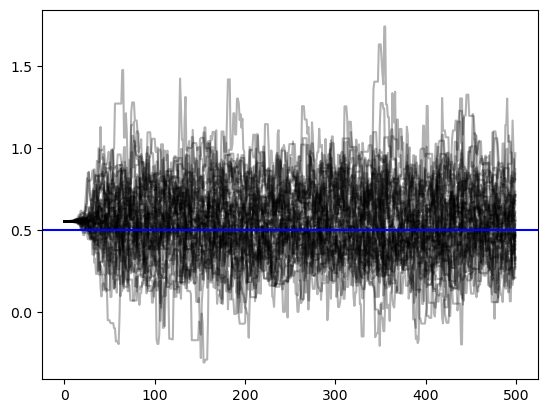

In [64]:
from numpy import isfinite, inf

Nwalker,Ndim = 50,4
p0 = [result['x']+1.e-4*np.random.randn(Ndim) for i in range(Nwalker)]

sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,
                                args=(x_true,y_true,z_obs))
pos,prob,state = sampler.run_mcmc(p0, 500)

res= plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(alpha_true, color='blue')                                   # Plot of the traces of the walkers

Now to reset the chain and run again for more steps. As before, using the flatchain argument to concantenate N and Ndims. The median value is calculated and plotted against model

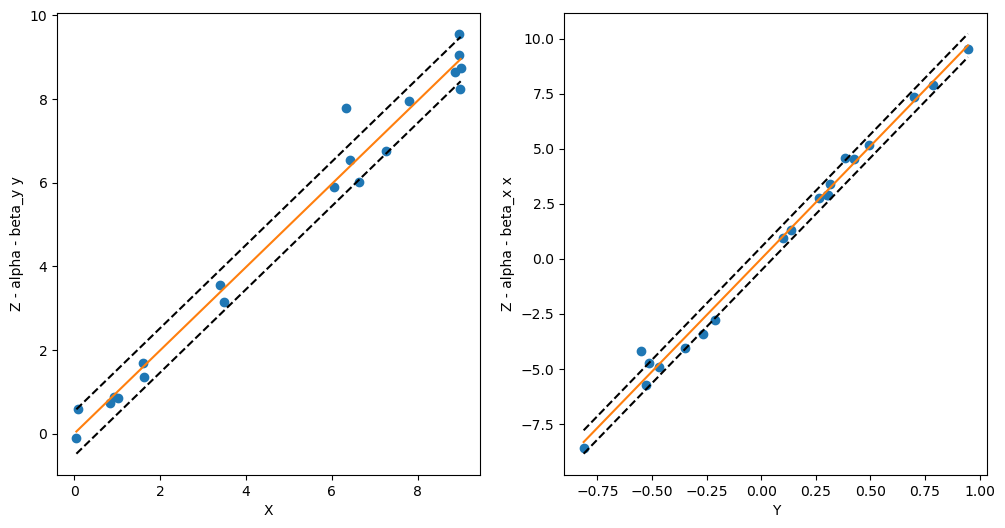

In [68]:

sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 1000)

m_alpha,m_betax,m_betay,m_eps = np.median(sampler.flatchain, axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_true, z_obs-m_alpha-m_betay*y_true, 'o')
plt.xlabel('X')
plt.ylabel('Z - alpha - beta_y y')
# Now plot the model
xx = np.array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')
plt.subplot(1,2,2)
plt.plot(y_true, z_obs-m_alpha-m_betax*x_true, 'o')
plt.xlabel('Y')
plt.ylabel('Z - alpha - beta_x x')
yy = np.array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')


We can find the covariance of the patterns to form probability distributions. To do so, the 2D Markov chains are required, which are already neatly organised by using flatchain.

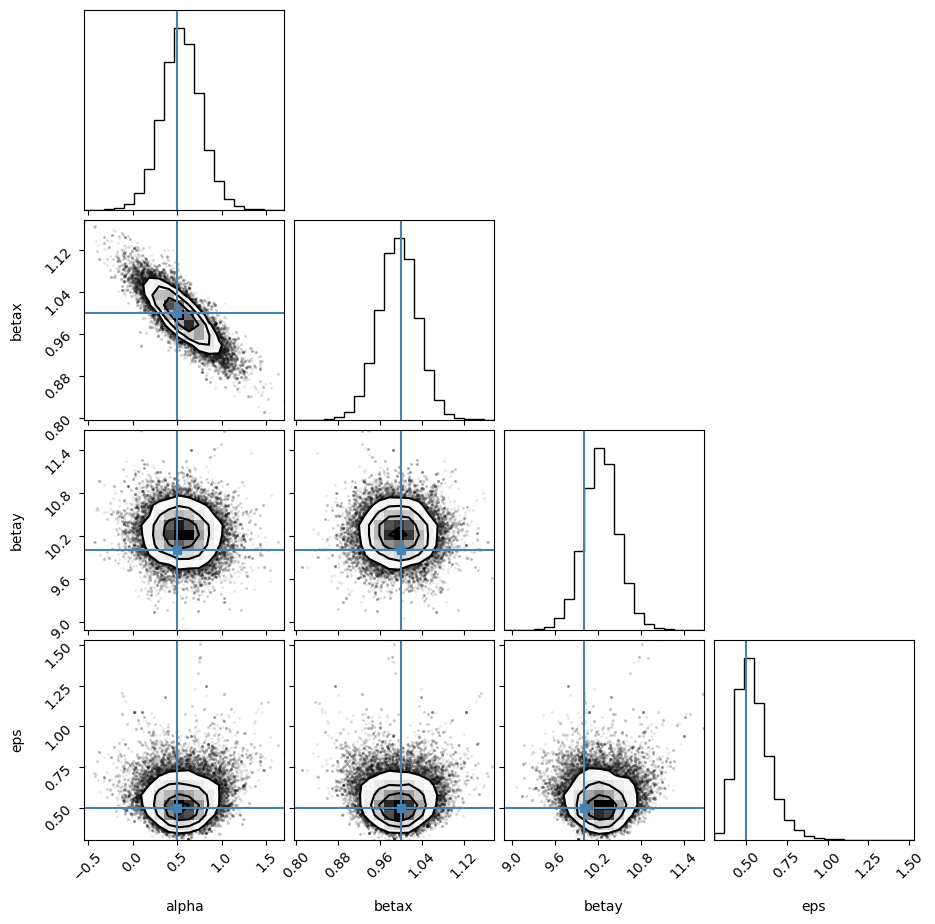

In [71]:
import corner
tmp = corner.corner(sampler.flatchain, labels=['alpha','betax','betay','eps'], 
                truths=[alpha_true, beta_x_true, beta_y_true, eps_true])